# Deskewing pages
This notebook was designed to introduce one method for automatically deskewing page images in preparation for OCR. For our purposes in this iteration of the class, the details of the process are less important than seeing an example of the ways that images can be computationally changed after initial photography: when you're looking at a digital surrogate, you're seeing an image that has likely been through several processes that attempt to optimize it for the task at hand without a human having to check it at each step of the way.

For today, there's **really** no need to try to figure out any of the details of the code: the more important thing is to get a general sense of what's happening, and then observe the differences that those changes make to the image in the end.

The code in this notebook is drawn from a blog post by Leo Ertuna at [Becoming Human](https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df), but with an adjustment that some experimenting suggests seems to work better for early print.

### A note before we start: this may not be the only problem to solve
The code in this notebook assumes that the problem with the page image is that it's skewed and needs to straightened—this treats the page as a two-dimensional plane.

That works pretty well if the images are of reasonably flat pages of the kind that we can often get from the sort of imaging labs that many libraries have. But books don't necessarily lay flat, and, depending on the condition of the binding, it may not always possible to flatten the pages for imaging. So the lines of text in some images will appear not just skewed, but actually curved, due to the curvature of the pages. And pages in a book can curl in a number of ways all at once (recall, for instance how much more and how differently the pages in the middle of a thick book curl compared to pages at the beginning or end.)

It's possible to reduce or eliminate the appearance of curvature in the lines of a page image incorporating some of techniques we'll see in this deskewing routine (but adding some others). That's a more complicated problem that we won't take on, but there's a great [blog post by Mark Zucker](https://mzucker.github.io/2016/08/15/page-dewarping.html) that walks through a solution. The blog post offers visualizations of what's happening at each step, so it's an instructive read even if you're not examining the details of the code. In the interests of time, I'll urge you **not** to examine the details of the code today, but to skim Zucker's description of his approach to the problem and look at the illustrations that visualize what the code is *doing*.

## 1 - Connect to Google Drive, copy files, and install packages

In [ ]:
#Code cell #1
#Get access to Google Drive
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
#Code cell #2
%cp -r /gdrive/MyDrive/rbs_digital_approaches_2023/output/cropped.zip /content/cropped.zip
%cd /content/
!unzip cropped.zip

In [ ]:
#Code cell #3
#Install IPyWidgets to provide widgets for experimenting with some variables later
import ipywidgets as widgets
from ipywidgets import interact

#Import necessary Python packages for use in our code.

#Note that opencv-python is installed by default in Google Colaboratory. If you
#were working in a different environment, you'd need to be sure it was installed
#using pip

#(The second import is specific to Google Colaboratory and provides a workaround
#to get OpenCV's imshow command to work properly in a Colab notebook.
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

## 2 - Opening the image

In [ ]:
#@title Select an image
 #@markdown Run this cell to create a select
 #@markdown list widget that allows us to
 #@markdown choose an image to process. With
 #@markdown an image selected (a default is
 #@markdown provided), you can continue
 #@markdown working through the code below.
 #@markdown FYI: 1730f_p0iv, 1730g_p21, and
 #@markdown 1730j_p21 are the best examples
 #@markdown of skewed pages in this set.

 #@markdown You only need to run this cell once (re-running it will just set things back to the default value). But you can change the image you're working with using the select list in order to see how these processes work given different starting images.

 #@markdown >Note: `1730f_p14-cropped.tif` is here to show a nasty surprise! Try some others first.
import os
import glob
file_list = sorted([os.path.basename(file) for file in glob.glob('/content/cropped/*.tif')])
image_select = widgets.Dropdown(
    description='Choose image',\
    options = file_list,\
    value = '1730f_p0iv-cropped.tif',
    style={'description_width': 'initial'})
display(image_select)

In [ ]:
#Code cell #5
#Identify the skewed image and have OpenCV read it. (This can take a little
#while, so give it time to complete.)

source_directory = '/content/cropped/'
skewed_image = source_directory + image_select.value
im = cv2.imread(skewed_image, cv2.IMREAD_COLOR)
#Let's see what the image looks like: an excellent image, but a little skewed.
cv2_imshow(im)

## 3 - Deskewing the image
OCR software like Tesseract might well be able to handle an image like this, but recognition of text lines will be better if we can straighten it. Ertuna's script offers a nice example of a workflow for figuring out exactly *how* skewed the image is, then using that measurement to straighten the image. As we proceed, you'll see some of the ways that images that are good for *us* are not as useful for the computer, and vice versa.

A lot of what we do in this notebook will look familiar from our cropping procedure, but we'll see there are some slight differences, too.

In [ ]:
#Code cell #6
#Make a copy of the image
newImage = im.copy()
#Convery to grayscale
gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
#Apply a Gaussian blur to reduce the effect of any noise in the image
blur = cv2.GaussianBlur(gray, (9, 9), 0)
#Convert the image to inverted black and white (i.e., white text on a
#black background). Note that Ertuna's script uses Otsu's method for
#thresholding to black and white.
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
cv2_imshow(thresh)

### 3.a - Set kernel size for dilation
Run the next cell to create a few sliders that will allow you to adjust the variables used in the next steps. (You only need to run that cell once. Thereafter, changing the sliders will change the values of the variables used in the subsequent cells.)

In [ ]:
#@title Set kernel size {display-mode: "form"}

#@markdown Run the code in this cell to create a set of
#@markdown slider widgets for changing the values of the
#@markdown "kernel" used to dilate the white pixels in the
#@markdown image. You can change the height and width of the
#@markdown kernel (i.e., the amount of vertical and horizontal
#@markdown dilation to be applied) as well as the number of
#@markdown iterations (how many times the dilation operation
#@markdown will be applied.)

#@markdown You only need to run this cell once (re-running
#@markdown it will just re-set the values to their defaults).
#@markdown You can change the values of the sliders and
#@markdown then run Code cell 12 to see the different
#@markdown effects that different values have.
kernel_width = widgets.IntSlider(description = 'Kernel width', \
                                               min=1, max=25, step=1, value=20)
kernel_height = widgets.IntSlider(description='Kernel height', \
                                                 min=1, max=25, step=1, value=1)
num_iterations = widgets.IntSlider(description='Iterations', min=1, \
                      max=10, step=1, value=3)
display(kernel_width)
display(kernel_height)
display(num_iterations)

### 3.b - This is weird, but we've seen this before
Just as we did when we were trying to identify the text block to crop, we're going to create recognizable text *regions* by dilating white pixels of the text until they run together to form solid blocks of white. The sliders are set to default values that will tend to do this, but you should play around with them to see how the image responds to different settings.

In [ ]:
#Code cell #7
#The kernel variable defines a shape to use for dilating the pixels. If the kernel
#is wider than it is tall, the text will tend to run together while more or less
#maintaining the vertical dimensions of the text lines.
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_width.value, kernel_height.value))

dilate = cv2.dilate(thresh, kernel, iterations=num_iterations.value)
cv2_imshow(dilate)

This cell finds the boundaries of the dilated white blocks that used to be our text lines and determines their contours.
I've made an adjustment to Ertuna's approach here in using the `RETR_EXTERNAL` method rather than the `RETR_LIST` method that he used. Ertuna's method retrieves *all* contours that are detected, where `RETR_EXTERNAL` ignores contours that are found *within other contours*. Though I can't say I've tested it entirely systematically, this approach seems to do a better job of detecting text blocks in this eighteenth-century text, where what may be wandering in the baseline of the set type creates some gaps that end up being detected as contours.

In [ ]:
#Code cell #8
#Determine contours
contours, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#These next steps are not really part of the deskewing sequence. I've included
#them simply so we can see what's happening. We first create a color version
#of our black-and-white image, then draw a bright green line connecting the
#contour points so we can see the outlines of the detected shapes
show_contours = cv2.cvtColor(dilate, cv2.COLOR_BayerGR2RGB)
show_contours = cv2.drawContours(show_contours, contours, -1, (115,255,105), 3)
cv2_imshow(show_contours)

### 3.c - Finding the rectangles that fit these contours
In the last notebook, we used `boundingRect` to find *straight* bounding rectangles around the text contours. Our problem is slightly different here, since we're interested in lines that *aren't* straight. Indeed, how far they are from being straight is exactly what we want to know.

OpenCV's `minAreaRect` finds the *smallest possible* rectangle that will contain the contour, even if that that smallest possible rectangle is rotated relative to the square edges of the image (as it almost surely will be).

This really seems like a case where a picture is worth a thousand words, so here's a picture taken from the OpenCV documentation. (The green rectangle is produced by `boundingRect` while the red one is produced by `minAreaRect`.)



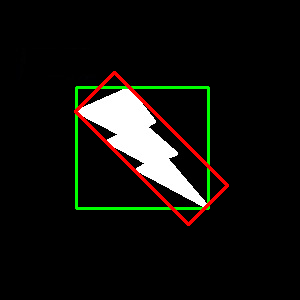

`minAreaRect` is the right choice for this de-skewing problem because it provides:

* the x, y coordinates of the center point of the rectangle;
* the width and height of the rectangle; and
* the *rotation angle* of the rectangle—which is what we're trying to correct for. (For more on how `minAreaRect` treats this angle, see [this post at *The AI Learner*](https://theailearner.com/tag/cv2-minarearect/).)

Ertuna's script acts on only the largest of the detected areas on the not-unreasonable premise that the skew angle of the largest text block will be a good proxy for the skew angle of the entire page of text. (He notes, though, that other approaches are possible. One might find that the angle of a different block yielded better results, or the average of multiple blocks.) This seems like it would be a pretty sound approach if we were dealing with deskewing, say, a page printed from a laser printer that had subsequently been scanned with the paper skewed slightly on a scanner bed.

But while this approach seemed to work well for images from a copy of *Sophonisba* from the University of Pennsylvania that were significantly skewed, it actually seemed to make things slightly *worse* for some pages that were only minimally skewed. I'm not entirely sure what to make of this yet, but my hunch is that this result may arise from the character of pages produced on a printing press. Perhaps if the chase wasn't locked up tightly, different lines on the same page could deviate from horizontal by *different* amounts?

Rather than relying solely on the largest text block, the code below sets a couple of thresholds to detect as many text blocks as possible (while rejecting regions that seem like they're probably noise), then figures out an average angle for deskewing the entire page.

>*Note:* The code in the following cell is, again, not strictly part of the deskewing procedure, but I have added it to show what's happening.

In [ ]:
#Code cell #9
def draw_min_area_rect(cv2minimumarearectangle, base_image) :
  draw_min_area_rect = base_image.copy()
  #If we have more than one recttangle...
  if isinstance(cv2minimumarearectangle, list) == True :
    print(len(cv2minimumarearectangle))
    for rect in cv2minimumarearectangle :
      #boxPoints gets the coordinates of the four corners of the rotated rectangle,
      #which is nice, because figuring them out ourselves would be sort of a drag,
      #given the way those rectangles are (of necessity) represented in OpenCV.
      min_area_box = cv2.boxPoints(rect)
      #Turn corner coordinates into integers
      min_area_box = np.int0(min_area_box)
      #Draw this rectangle one side at a time, beginning from the upper left
      #corner and working clockwise.
      draw_min_area_rect = cv2.line(draw_min_area_rect, (min_area_box[0][0], min_area_box[0][1]), \
                                    (min_area_box[1][0], min_area_box[1][1]), (0, 30, 255), 3)
      draw_min_area_rect = cv2.line(draw_min_area_rect, (min_area_box[1][0], min_area_box[1][1]), \
                                    (min_area_box[2][0], min_area_box[2][1]), (0, 30, 255), 3)
      draw_min_area_rect = cv2.line(draw_min_area_rect, (min_area_box[2][0], min_area_box[2][1]), \
                                    (min_area_box[3][0], min_area_box[3][1]), (0, 30, 255), 3)
      draw_min_area_rect = cv2.line(draw_min_area_rect, (min_area_box[3][0], min_area_box[3][1]), \
                                    (min_area_box[0][0], min_area_box[0][1]), (0, 30, 255), 3)
      #Print the angle of rotation in the center of the rectangle
      cv2.putText(draw_min_area_rect, str(rect[-1]),
                  (int(rect[0][0]) -100, int(rect[0][1])), cv2.FONT_HERSHEY_SIMPLEX,
                  1, (0, 30, 255, 255), 3)
  else :
    min_area_box = cv2.boxPoints(cv2minimumarearectangle)
    min_area_box = np.int0(min_area_box)
    #This gnarly code again... I should really refactor this into a function,
    #because I hate looking at it, and once is bad enough.
    draw_min_area_rect = cv2.line(draw_min_area_rect, (min_area_box[0][0], min_area_box[0][1]), \
                                  (min_area_box[1][0], min_area_box[1][1]), (0, 30, 255), 3)
    draw_min_area_rect = cv2.line(draw_min_area_rect, (min_area_box[1][0], min_area_box[1][1]), \
                                  (min_area_box[2][0], min_area_box[2][1]), (0, 30, 255), 3)
    draw_min_area_rect = cv2.line(draw_min_area_rect, (min_area_box[2][0], min_area_box[2][1]), \
                                  (min_area_box[3][0], min_area_box[3][1]), (0, 30, 255), 3)
    draw_min_area_rect = cv2.line(draw_min_area_rect, (min_area_box[3][0], min_area_box[3][1]), \
                                  (min_area_box[0][0], min_area_box[0][1]), (0, 30, 255), 3)
    cv2.putText(draw_min_area_rect, str(cv2minimumarearectangle[-1]),
                (int(cv2minimumarearectangle[0][0]) -100, int(cv2minimumarearectangle[0][1])),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 30, 255, 255), 3)

  return draw_min_area_rect

In [ ]:
#Code cell #10
#Actually draw the rectangles using the function defined in code cell 9.

#Make an image to render
draw_rects = show_contours.copy()
#An empty list for our minAreaRects
rects = []

#Iterate through the contours
for contour in contours :
  #Find the minAreaRect for each contour
  minAreaRect = cv2.minAreaRect(contour)
  #minAreaRects with a height of less than 60 pixels seemed almost always to be
  #artifacts of noise, rather than text blocks we'd actually be interested in.
  if minAreaRect[1][1] > 60 :
    #Let's ignore any text block that appears to be perfectly horizontal--or
    #rotated 90 degrees. On a normal page, any text block in the latter category
    #almost always seems to be noise (like a shadow in the gutter or at the
    #margin).
    if minAreaRect[-1] not in [-0.0, 0.0, -90.0, 90.0] :
      #If it's passed both of these tests, add it to our list.
      rects.append(minAreaRect)

#Draw all of the minAreaRects that met our thresholds
for rect in rects :
  draw_rects = draw_min_area_rect(rect, draw_rects)
cv2_imshow(draw_rects)

###3.d - Calculating an average angle to use for deskewing

This cell averages the rotation angles of the `minAreaRect`s in order to figure out how much to rotate the image in order to straighten it.

>Note: While updating this notebook, I ran into what I believe may have been some changes introduced in OpenCV which required some modifications to code I wrote a while back. (Alternatively, I may have just uncovered some errors in my earlier code!) I'm not sure I've gotten my head around these changes, entirely, so while I've checked to see that the *output* is correct, I'm not sure my explanations are. For further discussion of this problem, see: https://starecat.com/content/wp-content/uploads/my-code-doesnt-work-i-have-no-idea-why-my-code-works.jpg

In addition to knowing what the angles for the blocks of text are, we do need to keep track of which *direction* each block is skewed. This cell uses an I-was-pleasantly-surprised-it-actually-worked method of figuring out the *prevailing* direction of skewing on the page in order to determine whether we should use a positive or negative angle to deskew the page.

In [ ]:
#Code cell #11
#Create an empty list that will hold a series of tuples: the first element will
#be the angle, and the second will be either 1 or -1)
angle_corrections = []
for rect in rects :
  if 45 < rect[-1] < 90 :
    #For angles of more than 45 degrees, construct a tuple with
    #the deviation from 90 degrees (rendered as a negative number) as the
    #first term (e.g., 90 - (-1 * -87.6834) = 90 - 87.6834 = 2.3166)
    #and -1 as the second
    angle_corrections.append((-1* (90 - (rect[-1])), -1))
  else :
    #For angles of less than 45 degrees construct a tuple with
    #the deviation from 90 degrees as the first term
    #(e.g. 90 - 90 + -1.4596 = 90 - 88.5404 = 1.4596)
    #and 1 as the second term
    angle_corrections.append((90 - (90 + rect[-1]), 1))
#Determine the mean of the first terms of all of the tuples
#in our list of angle_corrections. Note this is line is using list comprehension
#syntax: https://www.w3schools.com/python/python_lists_comprehension.asp
average_angle = np.mean([angle_tuple[0] for angle_tuple in angle_corrections])

#Determine whether the deskew angle should be treated as positive
#or negative by taking the sum of the second terms of all
#of the tuples (e.g., -1 + -1 + -1 + 1 + -1 = -3)
plus_or_minus = sum(angle_tuple[1] for angle_tuple in angle_corrections)
#If that sum ends up as a positive number, the deskewing angle
#needs to be a negative number
if plus_or_minus > 0 :
  average_angle = -1.0 * average_angle
print(plus_or_minus)
print(average_angle)

In [ ]:
for angle_correction in angle_corrections :
  print(angle_correction)

### 3.e - Let's see the deskewed image.
The code in the next cell takes a few steps to rotate our image
1. First, we make a copy of our original image
2. Next, we determine the size of the image by getting its height and width (the first two items returned by `shape`)
3. Then, we determine the center of the image by dividing its height and width by two.
4. Next, we construct the rotation we want to happen: rotating the image around its center point by the `angle` we determined in the previous cell.

Note how we're using information that we calculated by using what is to us a very strange-looking image, and applying it to our original color image.

In [ ]:
#Code cell 12
average_angle_deskew = im.copy()
(h, w) = average_angle_deskew.shape[:2]
center = (w // 2, h // 2)
# M = cv2.getRotationMatrix2D(center, angle, 1.0)
M = cv2.getRotationMatrix2D(center, average_angle, 1.0)
deskewed_average_angle = cv2.warpAffine(average_angle_deskew, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
cv2_imshow(deskewed_average_angle)

###3.f - Automatically deskewing the image
As in the last notebook, we've walked through each step of this process to see how it works. But once we've figured out how to do it, we can write a function to call using a `for` loop.

In [ ]:
#Code cell 13
def deskew_image(image) :
  #Convert to gray
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  #Apply Gaussian blur
  blur = cv2.GaussianBlur(gray, (9, 9), 0)
  #Invert
  thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  #Define the kernel
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
  #Dilate
  dilate = cv2.dilate(thresh, kernel, iterations=5)
  #Determine contours
  contours, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  #Decide which contours to keep
  rects = []
  for contour in contours :
    minAreaRect = cv2.minAreaRect(contour)
    if minAreaRect[1][1] > 60 :
      if minAreaRect[-1] not in [-0.0, 0.0, -90.0, 90] :
        rects.append(minAreaRect)
  #Average the angle needed to deskew, and determine in which direction
  angle_corrections = []
  for rect in rects :
    if 45 < rect[-1] < 90 :
      angle_corrections.append((-1* (90 - (rect[-1])), -1))
    else :
      angle_corrections.append((90 - (90 + rect[-1]), 1))
  average_angle = np.mean([angle_tuple[0] for angle_tuple in angle_corrections])
  plus_or_minus = sum(angle_tuple[1] for angle_tuple in angle_corrections)
  if plus_or_minus > 0 :
    average_angle = -1.0 * average_angle
  #Use averaged angle to rotate the original image around its center
  average_angle_deskew = image.copy()
  (h, w) = average_angle_deskew.shape[:2]
  center = (w // 2, h // 2)
  M = cv2.getRotationMatrix2D(center, average_angle, 1.0)
  deskewed = cv2.warpAffine(average_angle_deskew, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
  #Return the deskewed image
  return deskewed



In [ ]:
#Code cell 14
if not os.path.exists('/content/deskewed/') :
  os.makedirs('/content/deskewed/')
for file in glob.glob('/content/cropped/*.tif') :
  basename = os.path.basename(file)[:-4]
  basename += '-deskewed.tif'
  original = cv2.imread(file, cv2.IMREAD_COLOR)
  deskewed = deskew_image(original)
  cv2.imwrite('/content/deskewed/' + basename, deskewed)
  print('Saved ' + basename)

In [ ]:
#Code cell 15
%cd /content/
!zip -r deskewed.zip deskewed/
!mv /content/deskewed.zip /gdrive/MyDrive/rbs_digital_approaches_2023/output/deskewed.zip


##4 - NOW we can automate optimized binarization
Now that we can crop and deskew the text block, we can be more confident that the images we produce will be useful for OCR.

The next cells return to the code from code cell 6 in the previous notebook, but step through them a little more deliberately to show how one other parameter can affect the images we produce.

We'll step through the process of automatic binarization using Otsu's method, then write a function that we can call for each image using a `for` loop.

In [ ]:
#Code cell 16
text_block = cv2.imread('/content/deskewed/1730g_p21-cropped-deskewed.tif',
                        cv2.IMREAD_COLOR)
cv2_imshow(text_block)

###4.a - Convert to grayscale
Nothing too exotic here: just throwing away the color information, but keeping everything else.

In [ ]:
#Code cell 17
text_block_gray = cv2.cvtColor(text_block, cv2.COLOR_BGR2GRAY)
cv2_imshow(text_block_gray)

### 4.b - Applying a Gaussian blur
We could simply convert our grayscale image to black and white right now, but there are arguments for applying a slight blur to our image first. While it seems counterintuitive that we would want to make an image blurrier when what we want to do is to recognize text clearly, that blurring can help to minimize the effect of any noise in the image (including, say, tiny flecks in the paper).

(Be sure to run the next cell, as it creates a widget for adjusting the blur that we'll apply in the cell following it.)

In [ ]:
#@title Set values for Gaussian blur {display-mode: "form"}
#@markdown Try adjusting the value that will be used for blurring in the next cell.

#@markdown (You only need to run this cell once—re-running it will simply reset it to the default value. After changing the value of the slider, try re-running the cell below this one.)
blur = widgets.IntSlider(min=1, max=31, step=2, value=5, description='Blur')
display(blur)


In [ ]:
#Code cell 21
text_block_blurred = cv2.GaussianBlur(text_block_gray, (blur.value, blur.value), 0)

cv2_imshow(text_block_blurred)

### 4.c - Determining an appropriate threshold using Otsu's method
We'll experiment with two different methods for automatically thresholding our image. The first, Otsu's method (as best I understand without actually being able to follow the equations) arrives at a threshold level for the image as a whole by noting the distribution of intensities across *all* the pixels of an image and finding the threshold level that optimally divides those intensities into two clusters: the point at which it makes most sense to say "Everything greater than this belongs together in one group, and everything less than this belongs together in a different group." The "greater than" group gets turned to black, and the "less than" group gets turned to white.

This is more or less what we were trying to do experimentally by changing the threshold value in Section 3, but without the trial and error. Once we've cropped the image to eliminate the pronounced black border, Otsu's method seems to work quite well for the kinds of page images we're dealing with, as we'll see in the cell below. (Notice how much better this one looks than the first time we tried it on the uncropped images back in code cell 10,  and notice, too, how different the threshold value turns out to be this time than the 108 that the method produced above. How does it compare to the value you arrived at through trial and error in code cell 8?)

>*Note:* Make sure that the blurred image you've created in the cell above looks good to you, since that's what we'll be thresholding here. If you had experimented with the blur until it started looking terrible, now would be the time to set it back to a more sensible level.

In [ ]:
#Code cell 22
(T_new, text_block_otsu) = cv2.threshold(text_block_blurred, 0, 255, cv2.THRESH_OTSU)

#Output
cv2_imshow(text_block_otsu)
print('Otsu threshold is: ' + str(T_new))

>*Note:* When I've timed these things, the conversion using Otsu's method in OpenCV works out to be somewhat slower than using `Pillow` with a manual threshold level. But we can be more confident that this method has found a good threshold for any given image. If we were trying to automate the conversion of scores (or hundreds, or thousands) of images, the tradeoff in speed for adaptability would probably be worth it.

### 4.d - Binarize the images
This ends up being a pretty short function, which we can call with a `for` loop.

In [ ]:
#Code cell 23
def binarize_image(image) :
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  (T, otsu) = cv2.threshold(blurred, 0, 255, cv2.THRESH_OTSU)
  return otsu

In [ ]:
#Code cell 24
if not os.path.exists('/content/bw/') :
  os.makedirs('/content/bw/')
for file in glob.glob('/content/deskewed/*.tif') :
  basename = os.path.basename(file)[:-4]
  basename += '-bw.tif'
  original = cv2.imread(file, cv2.IMREAD_COLOR)
  binarized = binarize_image(original)
  cv2.imwrite('/content/bw/' + basename, binarized)
  print('Saved ' + basename)

###4.e - Let's get three more black and white derivatives for experimental purposes
We've gone through this whole process so that we could get images that were in a condition to binarize using Otsu's method so that the computer could calculate an optimum thresdhold value for us.

In order to see the impact that differing image quality can have on the OCR output, let's create three different derivatives of the same image using different threshold values. We'll try OCRing all three to compare the output.

In [ ]:
#Code cell 25
from PIL import Image
if not os.path.exists('/content/bw/') :
  os.makedirs('/content/bw/')

pilcolor_image = Image.open('/content/deskewed/1730f_p21-cropped-deskewed.tif')
pilgray_image = pilcolor_image.convert('L')
thresh_values = [95, 145, 175]
fn = lambda x : 255 if x > thresh else 0
for thresh_value in thresh_values :
  thresh = thresh_value
  pilbinary_image = pilgray_image.convert('L').point(fn, mode='1')
  output_filepath = '/content/bw/1730f_p21_manual_'+ str(thresh) + '.tif'
  pilbinary_image.save(output_filepath)


In [ ]:
#Code cell 26
%cd /content/
!zip -r bw.zip bw/
!mv /content/bw.zip /gdrive/MyDrive/rbs_digital_approaches_2023/output/bw.zip


##5 - Possible limitations of Otsu's method
Otsu's method seems to work great for these page image. We could imagine circumstances, though, where the results wouldn't be so good. In an image where the separation between light and dark pixels was less clear, the threshold determined by Otsu's method might yield a result that was difficult to read. This could be the case, for instance, with an image of a page with lots of ink showing through from the other side, or with too much shadow on the page from less-than-ideal photographic circumstances, or, as we'll see in the next cell, with severe foxing of the paper.

In [ ]:
#Code cell #26
%cp /gdrive/MyDrive/L-100\ Digital\ Approaches\ to\ Bibliography\ \&\ Book\ History-2023/2023_page_images.zip /content/2023_page_images.zip
%cd /content/
!unzip 2023_page_images.zip
foxed = '/content/2023_page_images/st_tz_foxing.jpg'
color_foxed = cv2.imread(foxed, cv2.IMREAD_COLOR)
cv2_imshow(color_foxed)

How does Otsu's method do with this image? Wellll...

(Note that this is just an image I found in a [blog post from the New England Document Conservation Center](https://www.nedcc.org/about/nedcc-stories/story-tz-interview), and not an image that was created through careful digitization. Still, if you've spent any time working with scanned books, you've surely seen something like this before.)

In [ ]:
#Code cell #27
gray_foxed = cv2.cvtColor(color_foxed, cv2.COLOR_BGR2GRAY)
blurred_foxed = cv2.GaussianBlur(gray_foxed, (5, 5), 0)
otsu_foxed = cv2.threshold(blurred_foxed, 0, 255, cv2.THRESH_OTSU)[1]

cv2_imshow(otsu_foxed)

### 6.e - Applying adaptive thresholding for problematic images
Rather than attempting to calculate a single threshold point appropriate for the image as a whole, adaptive thresholding first divides the image into segments based on the levels in different regions of the image and then calculates a separate threshold point for each segment. For a generally good image like our pages of *Sophonisba*, the difference isn't really all that noticeable. We can certainly see a difference, but it's not terribly dramatic.

In [ ]:
#Code cell #28
cv2binary_adaptive_image = cv2.adaptiveThreshold(text_block_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 30)
cv2_imshow(cv2binary_adaptive_image)

But it makes a *remakable* difference for the badly foxed title page we saw giving Otsu's method trouble:

In [ ]:
#Code cell #29
cv2binary_adaptive_image = cv2.adaptiveThreshold(blurred_foxed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 30)
cv2_imshow(cv2binary_adaptive_image)

## Takeaways
Images get converted to black and white for various reasons. At a practical level, the file sizes for black and white images are much smaller than for color images. So if the aim is simply to have a readable text, black and white images get the job done with less storage.

But black and white images are also easier for computers to work with in a number of ways, so images end up getting converted a lot for digital work.

Different images respond better to different treatments. Automated methods for figuring out likely-optimal values for thresholding any given image are necessary to do this kind of work at scale, but can lead to sometimes unexpected results.

When you're working with digital surrogates that have been converted to black and white, it's important to think about how the images may have been transformed so that you can try to work backwards to an at least plausible mental picture of the properties of the source item.